In [15]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py
from sklearn.utils import shuffle
from scipy.misc import logsumexp

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, z):
        z=np.atleast_2d(z)
        s = np.max(z, axis=1)
        s = s[:, np.newaxis] # necessary step to do broadcasting
        e_x = np.exp(z - s)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis] # dito
        return e_x / div
    
    def __softmax_deriv(self, a):
        #a = softmax(x)
        return (a * (1 - a))
    
    def __ReLU(self,x):
        return np.vectorize(lambda x:x if x>0 else 0)(x)
    
    def __ReLU_deriv(self,a):
        #a = ReLU()
        return np.vectorize(lambda x:1 if x>0 else 0)(a)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__logistic_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', dropout=None, W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.dropout=dropout
        self.dropout_vector = None
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input, mode):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        if (mode=='train' and self.dropout>0):
            self.dropout_vector = np.random.binomial(1, 1-self.dropout, size=input.shape)/(1-self.dropout)
            lin_output = np.dot(self.dropout_vector*input, self.W) + self.b
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
            )

        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input

        return self.output
    
    def backward(self, delta, output_layer=False):
        self.grad_W = np.atleast_2d(self.dropout_vector*self.input if self.dropout>0 else self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta,axis=0)
        
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh'], batch_size=False, dropout=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.mode = 'train'
        self.activation=activation
        self.dropout=dropout
        self.batch_size = batch_size
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],self.dropout[i]))
            
    def train(self):
        self.mode = 'train'
    
    def test(self):
        self.mode = 'test'

    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input=input, mode=self.mode)
            input=output
        return output

    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)
        # return loss and delta
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        error = y * np.log(y_hat)
        loss = -np.sum(error)
        delta = y_hat-y
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
            
    def get_batches(self,X, y, batch_size):
        batches = []

        X, y = shuffle(X, y)

        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            
            batches.append((X_batch, y_batch))

        return batches

    def fit(self,X,y,learning_rate=0.1, epochs=10, batch_size=False):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.batch_size=batch_size
        self.train()
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        y_dummies = np.array(pd.get_dummies(y))
        
        # Differentiate Stochastic Gradient Descent vs Batch Gradient Descent
        if batch_size:
            batches = self.get_batches(X, y_dummies, batch_size)
            for k in range(epochs):
                loss = np.zeros(X.shape[0])
                for X,y_dummies in batches:
                    # forward pass
                    y_hat = self.forward(X)
                    
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss,delta=self.criterion_CELoss(y_dummies,y_hat)
                    else:
                        loss,delta=self.criterion_MSE(y_dummies,y_hat)
                        
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate/batch_size)
                to_return[k] = np.mean(loss)
        else:
            for k in range(epochs):
                loss=np.zeros(X.shape[0])
                for it in range(X.shape[0]):
                    i=np.random.randint(X.shape[0])
                
                    # forward pass
                    y_hat = self.forward(X[i])
                
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss[it],delta=self.criterion_CELoss(y[i],y_hat)
                    else:
                        loss[it],delta=self.criterion_MSE(y[i],y_hat)
                
                    self.backward(delta)

                    # update
                    self.update(learning_rate)
                to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        self.test()
        x = np.array(x)
        output = np.zeros(x.shape[0])
        output = self.forward(x)
        return output
    
    def optimize(self, X, y, learning_rate=0.01, test_size=0.25, batch_size=False,epochs=10, verbose=True):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=test_size, shuffle=True)
        scaler = StandardScaler()
        #scaler = Normalizer()
        #scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        losses = np.zeros(epochs)
        accuracies_val = []
        accuracies_test = []
        if batch_size:
            batches = self.get_batches(X_train, y_train, batch_size)
            for k in range(epochs):
                loss = []
                for X,y_dummies in batches:
                    # forward pass
                    y_hat = self.forward(X)
                    
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        l,delta=self.criterion_CELoss(y_dummies,y_hat)
                    else:
                        l,delta=self.criterion_MSE(y_dummies,y_hat)
                    
                    loss.append(l)
                        
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate/batch_size)
                losses[k] = np.sum(loss)/X_train.shape[1]
                print(X_train.shape)
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                accuracies_val.append(accuracy_train)
                accuracies_test.append(accuracy_val)
                if verbose:
                    print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                          format(k, accuracy_train, accuracy_val, losses[k]))
        else:
            for k in range(epochs):
                loss=np.zeros(X.shape[1])
                for it in range(X.shape[0]):
                    i=np.random.randint(X.shape[0])
                
                    # forward pass
                    y_hat = self.forward(X[i])
                
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss[it],delta=self.criterion_CELoss(y[i],y_hat)
                    else:
                        loss[it],delta=self.criterion_MSE(y[i],y_hat)
                
                    self.backward(delta)

                    # update
                    self.update(learning_rate)
                losses[k] = np.mean(loss)
                
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                accuracies_val.append(accuracy_train)
                accuracies_test.append(accuracy_val)

                if verbose:
                    print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                          format(k, accuracy_train, accuracy_val, np.mean(loss)))
            
                losses[k] = np.mean(loss)
        return losses, accuracies_val, accuracies_test

In [11]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
    
mlp = MLP([128,128,32,10],activation=[None, 'ReLU','ReLU', 'softmax'], dropout=[0.0, 0.0, 0.0])

mlp.fit(X_train, y_train, learning_rate=0.1, batch_size=100, epochs=10)
predictions = mlp.predict(X_val)

In [18]:
print('Accuracy for these settings : {}'.format((np.argmax(predictions,axis=1)==y_val).mean()))

Accuracy for these settings : 0.8364791666666667


## Optimizing settings

Epoch: 0..
train Accuracy: 0.4550444444444444 
Validation Accuracy: 0.4452 
Loss: 755.0970435363752 

Epoch: 1..
train Accuracy: 0.7208888888888889 
Validation Accuracy: 0.7123333333333334 
Loss: 511.2415521779537 

Epoch: 2..
train Accuracy: 0.7930888888888888 
Validation Accuracy: 0.7892 
Loss: 296.10926291737434 

Epoch: 3..
train Accuracy: 0.8199555555555555 
Validation Accuracy: 0.8125333333333333 
Loss: 224.92535052224 

Epoch: 4..
train Accuracy: 0.8331333333333333 
Validation Accuracy: 0.8276666666666667 
Loss: 197.13198597455923 

Epoch: 5..
train Accuracy: 0.8417777777777777 
Validation Accuracy: 0.835 
Loss: 180.64339519032046 

Epoch: 6..
train Accuracy: 0.849 
Validation Accuracy: 0.8404 
Loss: 169.95818030798674 

Epoch: 7..
train Accuracy: 0.8543777777777778 
Validation Accuracy: 0.8436 
Loss: 161.93992272896827 

Epoch: 8..
train Accuracy: 0.8578444444444444 
Validation Accuracy: 0.8468 
Loss: 155.5216169498074 

Epoch: 9..
train Accuracy: 0.8616666666666667 
Validation

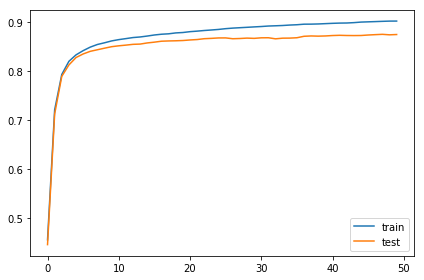

In [16]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,64,32,10],activation=[None, 'ReLU', 'ReLU', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, batch_size=1000,learning_rate=0.2,epochs=50)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

In [130]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,64,32,10],activation=[None, 'ReLU', 'ReLU', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.1,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

UnboundLocalError: local variable 'yhat_train' referenced before assignment

In [46]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,512,128,32,10],activation=[None, 'logistic', 'logistic', 'logistic', 'softmax'], dropout=[0.0, 0.0, 0.0, 0.0, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.02,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

(1,)
(32,)


ValueError: shapes (32,) and (1,1) not aligned: 32 (dim 0) != 1 (dim 0)

In [8]:
import tensorflow
import tensorflow as tf
import keras
config = tensorflow.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12} ) 
sess = tensorflow.Session(config=config) 
keras.backend.set_session(sess)

In [7]:
from keras.layers.core import Dense, Activation, Dropout
from keras import optimizers, metrics, Sequential

import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py

with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])

y = label
X = data

y_dummies = np.array(pd.get_dummies(y))
X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=0.25, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Crosscheck with Keras Library

In [69]:
with tf.device('GPU'):
    sgd = optimizers.sgd(momentum=0.9)
    model = Sequential()
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy',metrics.categorical_accuracy])
    model.fit(X_train, y_train, batch_size=100, epochs=20)

Epoch 1/20
45000/45000 [==============================] - 2s 42us/step - loss: 0.9828 - acc: 0.6622 - categorical_accuracy: 0.6622
Epoch 2/20
45000/45000 [==============================] - 1s 25us/step - loss: 0.5128 - acc: 0.8221 - categorical_accuracy: 0.8221
Epoch 3/20
45000/45000 [==============================] - 1s 25us/step - loss: 0.4623 - acc: 0.8380 - categorical_accuracy: 0.8380
Epoch 4/20
45000/45000 [==============================] - 1s 25us/step - loss: 0.4270 - acc: 0.8482 - categorical_accuracy: 0.8482 0s - loss: 0.4199 - acc:
Epoch 5/20
45000/45000 [==============================] - 1s 25us/step - loss: 0.4106 - acc: 0.8544 - categorical_accuracy: 0.8544
Epoch 6/20
45000/45000 [==============================] - 1s 25us/step - loss: 0.3929 - acc: 0.8596 - categorical_accuracy: 0.8596
Epoch 7/20
45000/45000 [==============================] - 1s 25us/step - loss: 0.3740 - acc: 0.8663 - categorical_accuracy: 0.8663
Epoch 8/20
45000/45000 [==============================] - 

In [3]:
#Predict and calculate accuracy
yhat_val = model.predict(X_val)

accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])

print('Keras model accuracy : {}').format(accuracy_val)

NameError: name 'model' is not defined